# Modelo de Credit Scoring

## Integrantes equipo 16:
- pedro_47553
- javiergrandat

# **PROBLEMA DE NEGOCIO**
---

La importancia de reducir el riesgo crediticio ha llevado a una institución financiera alemana a buscar soluciones innovadoras. Como científicos de datos, hemos sido convocados para construir un modelo de machine learning preciso y confiable que sea capaz de evaluar con mayor precisión la probabilidad de incumplimiento crediticio de sus clientes.

### **Tus tareas principales serán:**

**1. Preprocesamiento de Datos:** Realizar limpieza de datos, manejar valores faltantes, codificación de variables categóricas y normalización/escalado de datos.

**2. Exploración de Datos:** Analizar y comprender el conjunto de datos proporcionado, identificar variables llaves y realizar visualizaciones para entender las relaciones entre las variables y seleccionar las características relevantes.

**3. Construcción de Modelos:** Experimentar con algunos algoritmos de machine learning como Regresión Logística, Árboles de Decisión, Random Forest, Naive Bayes, entre otros.

**4. Evaluación y Selección del Modelo:** Evaluar los modelos utilizando métricas como precisión, recall, área bajo la curva ROC, y F1-score. Seleccionar el modelo con el mejor rendimiento para la predicción de la solvencia crediticia.

# 1. Cargue de librerías y datos
---

In [19]:
import warnings

import pandas as pd
import numpy as np
# Visualizacion
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
# Particionamiento
from sklearn.model_selection import train_test_split
# Preprocesamiento
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Modelos
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
# Metricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report
# Seleccion de modelos
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

In [20]:
df = pd.read_csv('./data/raw/german_credit.csv')
df.head()

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,other_debtors,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,none,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


# 2. Particionamiento del dataset
---

In [21]:
df.default.value_counts(normalize=True) * 100

default
0    70.0
1    30.0
Name: proportion, dtype: float64

In [22]:
rng = np.random.RandomState(0)
X = df.drop('default', axis=1)
y = df.default

In [199]:
# Particionamiento del dataframe original en set de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y,
                                                    test_size=0.2
                                                    )

In [24]:
print(y_train.value_counts(normalize=True) * 100)
print(y_test.value_counts(normalize=True) * 100)

default
0    70.0
1    30.0
Name: proportion, dtype: float64
default
0    70.0
1    30.0
Name: proportion, dtype: float64


# 3. Preprocesamiento
---

## Funciones para realizar label encoding de las variables categóricas

In [25]:
def account_check_status2num(df: pd.DataFrame) -> pd.DataFrame:
    categories = {
        '< 0 DM': 1, 
        '0 <= ... < 200 DM': 2, 
        'no checking account': 3,
       '>= 200 DM / salary assignments for at least 1 year': 4
    }
    
    df.account_check_status = df.account_check_status.map(categories)
    
    return df

def credit_history2num(df: pd.DataFrame) -> pd.DataFrame:
    categories = {
        'no credits taken/ all credits paid back duly': 1,
        'all credits at this bank paid back duly': 2,
        'existing credits paid back duly till now': 3,
        'delay in paying off in the past': 4,
        'critical account/ other credits existing (not at this bank)': 5
    }
    
    df.credit_history = df.credit_history.map(categories)
    
    return df

def purpose2num(df: pd.DataFrame) -> pd.DataFrame:
    categories = {
        'car (new)': 1,
        'car (used)': 2,
        'furniture/equipment': 3,
        'radio/television': 4,
        'domestic appliances': 5,
        'repairs': 6,
        'education': 7,
        '(vacation - does not exist?)': 8,
        'retraining': 9,
        'business': 10,
        'others': 11
    }
    df.purpose = df.purpose.map(categories)
    
    return df

def present_emp_since2num(df: pd.DataFrame) -> pd.DataFrame:
    categories = {
        '.. >= 7 years': 1, 
        '4 <= ... < 7 years': 2,
        '1 <= ... < 4 years': 3, 
        '... < 1 year ': 4,
        'unemployed': 5
    }
    df.present_emp_since = df.present_emp_since.map(categories)

    return df

def personal_status_sex2num(df: pd.DataFrame) -> pd.DataFrame:
    categories = {
        'male : divorced/separated': 1,
        'female : divorced/separated/married': 2,
        'male : single': 3,
        'male : married/widowed': 4,
        'female : single': 5
    }
    
    df.personal_status_sex = df.personal_status_sex.map(categories)
    
    return df

def other_debtors2num(df: pd.DataFrame) -> pd.DataFrame:
    categories = {
	    'none': 1,
	    'co-applicant': 2,
	    'guarantor': 3,
    }
    
    df.other_debtors = df.other_debtors.map(categories)
    
    return df

def property2num(df: pd.DataFrame) -> pd.DataFrame:
    categories = {
        'real estate': 1,
        'if not A121 : building society savings agreement/ life insurance': 2,
        'if not A121/A122 : car or other, not in attribute 6': 3,
        'unknown / no property': 4
    }
    
    df.property = df.property.map(categories)
    
    return df

def other_installment_plans2num(df: pd.DataFrame) -> pd.DataFrame:
    categories = {
        'bank': 1,
        'stores': 2,
        'none': 3,
    }
    df.other_installment_plans = df.other_installment_plans.map(categories)
    
    return df

def housing2num(df: pd.DataFrame) -> pd.DataFrame:
    categories = {
        'rent': 1,
        'own': 2,
        'for free': 3
    }
    df.housing = df.housing.map(categories)
    
    return df

def job2num(df: pd.DataFrame) -> pd.DataFrame:
    categories = {
        'unemployed/ unskilled - non-resident': 1,
        'unskilled - resident': 2,
        'skilled employee / official': 3, 
        'management/ self-employed/ highly qualified employee/ officer': 4
    }
    
    df.job = df.job.map(categories)
    
    return df

def telephone2num(df: pd.DataFrame) -> pd.DataFrame:
    categories = {
        'none': 0,
        'yes, registered under the customers name ': 1
    }
    df.telephone = df.telephone.map(categories)
    
    return df

def foreign_worker2num(df: pd.DataFrame) -> pd.DataFrame:
    categories = {
        'no': 0,
        'yes': 1,
    }
    df.foreign_worker = df.foreign_worker.map(categories)
    
    return df

def savings2num(df: pd.DataFrame) -> pd.DataFrame:
    categories = {
        '... < 100 DM': 1,
        '100 <= ... < 500 DM': 2,
        '500 <= ... < 1000 DM ': 3,
        '.. >= 1000 DM ': 4,
        'unknown/ no savings account': 5
    }
    df.savings = df.savings.map(categories)
    
    return df

def data_preprocessing(df:pd.DataFrame) -> pd.DataFrame:
    temp_df = df.copy()
    temp_df = temp_df.drop_duplicates()
    temp_df = temp_df.dropna()
    temp_df = (temp_df.pipe(account_check_status2num)
               .pipe(credit_history2num)
               .pipe(purpose2num)
               .pipe(present_emp_since2num)
               .pipe(personal_status_sex2num)
               .pipe(other_debtors2num)
               .pipe(property2num)
               .pipe(other_installment_plans2num)
               .pipe(housing2num)
               .pipe(job2num)
               .pipe(telephone2num)
               .pipe(foreign_worker2num)
               .pipe(savings2num)
    )
    
    return temp_df

In [26]:
banco_df = data_preprocessing(X_train)

# 4. Feature Engineering
---

## Funciones para discretizar variables numéricas

In [27]:
def duration_in_month2cat(df: pd.DataFrame,
                          bins: list,
                          labels: list, 
                          drop_column: bool=False) -> pd.DataFrame:
    df['rango_plazo'] = pd.cut(x=df.duration_in_month, bins=bins, labels=labels)
    df.rango_plazo = df.rango_plazo.astype(int)
    
    if drop_column:
        df = df.drop(['duration_in_month'], axis=1)
    
    return df

def credit_amount2cat(df: pd.DataFrame,
                      bins: list,
                      labels: list, 
                      drop_column: bool=False)-> pd.DataFrame:
    df['rango_valor_credito'] = pd.cut(x=df.credit_amount, bins=bins, labels=labels)
    df.rango_valor_credito = df.rango_valor_credito.astype(int)
    
    if drop_column:
        df = df.drop(['credit_amount'], axis=1)
    
    return df

def age2cat(df: pd.DataFrame,
            bins: list,
            labels: list, 
            drop_column: bool=False)-> pd.DataFrame:
    df['rango_edad'] = pd.cut(x=df.age, bins=bins, labels=labels)
    df.rango_edad = df.rango_edad.astype(int)
    
    if drop_column:
        df = df.drop(['age'], axis=1)
    
    return df

def sex_marital_status(df: pd.DataFrame)->pd.DataFrame:
    """
    sexo: {male:0, female: 1}
    estado_civil: {single: 1, other: 0}
    """
    df['sexo'] = np.where(df.personal_status_sex.isin([2, 5]), 1, 0)
    df.sexo = df.sexo.astype(int)
    df['estado_civil'] = np.where(df.personal_status_sex.isin([3, 5]), 1, 0)
    df.estado_civil = df.estado_civil.astype(int)
    df = df.drop(['personal_status_sex'], axis=1)
    
    return df

def feature_engineering(df: pd.DataFrame, drop_column: bool=False) -> pd.DataFrame:
    temp_df = df.copy()
    temp_df = (temp_df.pipe(sex_marital_status)
               .pipe(age2cat,
                     bins=[18, 30, 40, 50, 80],
                     labels=[1, 2, 3, 4],
                     drop_column=drop_column
                     )
               .pipe(duration_in_month2cat, 
                     bins=[1, 12, 24, 36, 72], 
                     labels=[1, 2, 3, 4],
                     drop_column=drop_column
                     )
               .pipe(credit_amount2cat, 
                     bins=[1, 1273, 1883, 2829, 4716, 20000],
                     labels=[*range(1, 6)],
                     drop_column=drop_column
                     )
            )
    return temp_df

In [28]:
banco_df = feature_engineering(banco_df, drop_column=False)

# 5. Análisis Exploratorio
---

In [29]:
def univariate_plot(df, varname, new_varname):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.kdeplot(data=df, x=varname, fill=True, ax=axes[0])
    sns.rugplot(data=df, x=varname, color='red', ax=axes[0])
    axes[0].set_title(f"Distribucion variable {varname}")
    sns.countplot(data=df, x=new_varname, palette="colorblind", ax=axes[1])
    axes[1].set_title(f"Distribucion variable {new_varname}")
    plt.show()

def bivariate_bad_plot(df, 
                       varname, 
                       target,
                       width=10, 
                       height=5,
                       show_text=True
                       ):
    tepm_df = df.groupby(varname)[target].value_counts(normalize=True)
    tepm_df = tepm_df.unstack().rename(columns={0: 'Bueno', 1: 'Malo'})
    tepm_df = tepm_df.T

    grupos = [*tepm_df.columns]
    buenos = tepm_df.loc['Bueno'].tolist()
    malos = tepm_df.loc['Malo'].tolist()

    fig, ax = plt.subplots(figsize=(width, height))
    ax.bar(grupos, buenos, label='Buenos')
    ax.bar(grupos, malos, bottom=buenos, label='Malos')
    ax.set_title(f"Tasa de malos por variable:{varname}")
    ax.set_ylabel("%")
    if show_text:
        for bar in ax.patches:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f'{round(bar.get_height() * 100, 2)}%',
                ha='center',
                weight='bold',
                color='w'
            )
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

## 4.1 Análisis Univariado

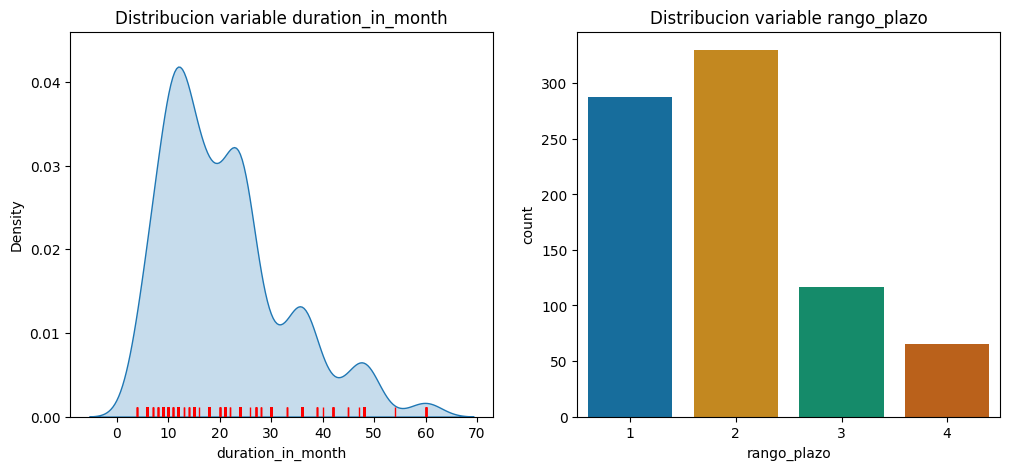

In [30]:
univariate_plot(banco_df, varname='duration_in_month', new_varname='rango_plazo')

In [31]:
banco_df.groupby('rango_plazo')['duration_in_month'].agg(['min', 'max', 'count']).eval("freq_rel = count / count.sum() * 100")

,min,max,count,freq_rel
rango_plazo,,,,
1,4,12,288,36.000
2,13,24,330,41.250
3,26,36,117,14.625
4,39,60,65,8.125


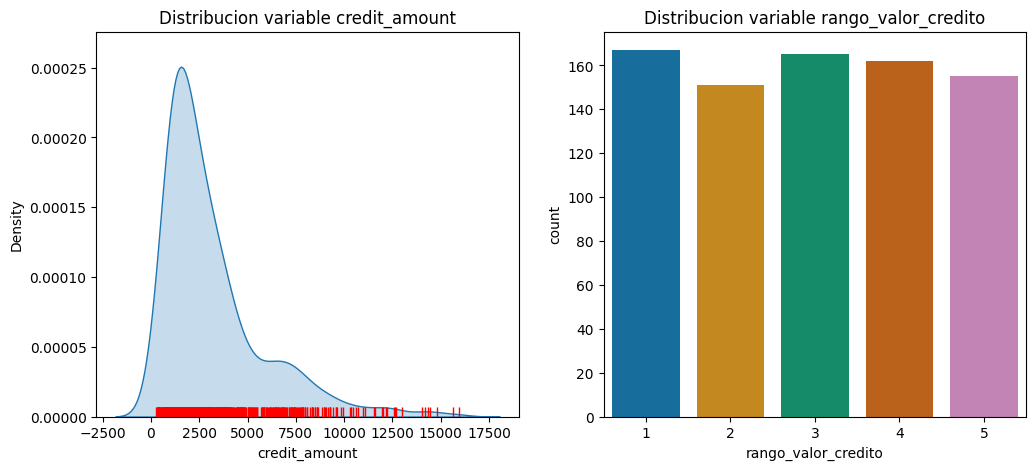

In [32]:
univariate_plot(banco_df, varname='credit_amount', new_varname='rango_valor_credito')

In [33]:
banco_df.groupby('rango_valor_credito')['credit_amount'].agg(['min', 'max', 'count']).eval("freq_rel = count / count.sum() * 100")

,min,max,count,freq_rel
rango_valor_credito,,,,
1,276,1271,167,20.875
2,1274,1882,151,18.875
3,1884,2828,165,20.625
4,2848,4716,162,20.250
5,4736,15945,155,19.375


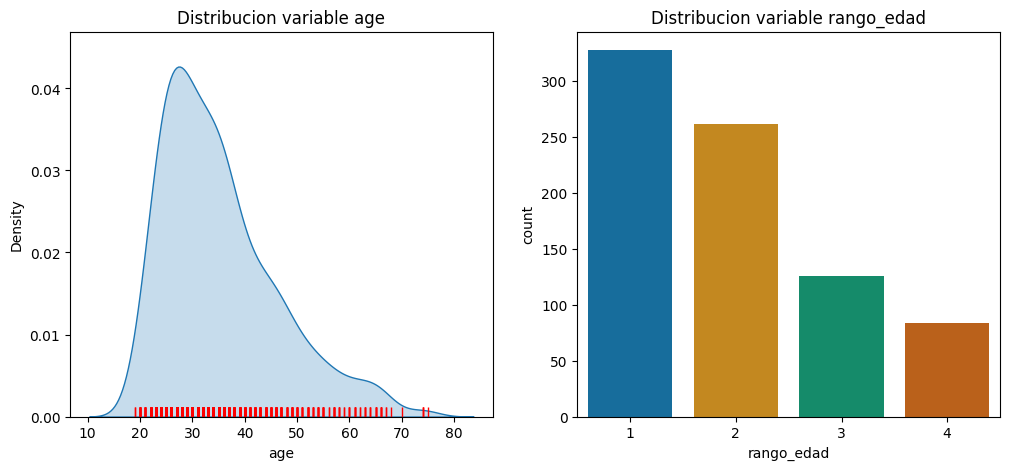

In [34]:
univariate_plot(banco_df, varname='age', new_varname='rango_edad')

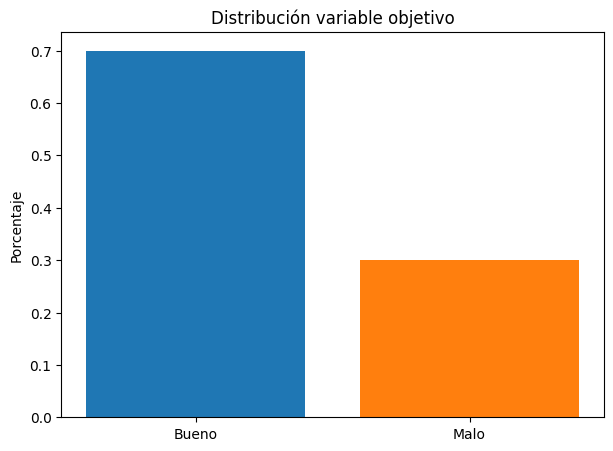

In [56]:
grupos = ['Bueno', 'Malo']
buenos = y_train.value_counts(normalize=True)[0]
malos = y_train.value_counts(normalize=True)[1]

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar('Bueno', height=buenos)
ax.bar('Malo', height=malos)
ax.set(
    title="Distribución variable objetivo",
    ylabel="Porcentaje"
)
plt.show()

## 4.2 Análisis Bivariado

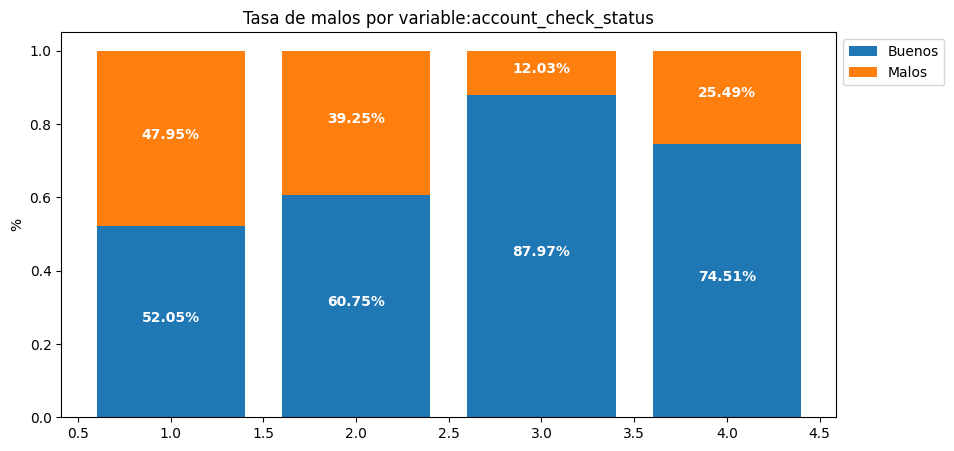

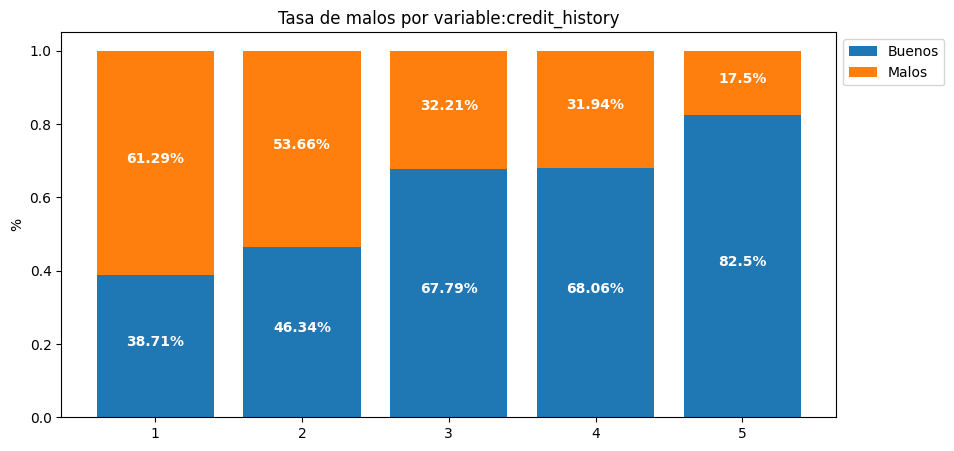

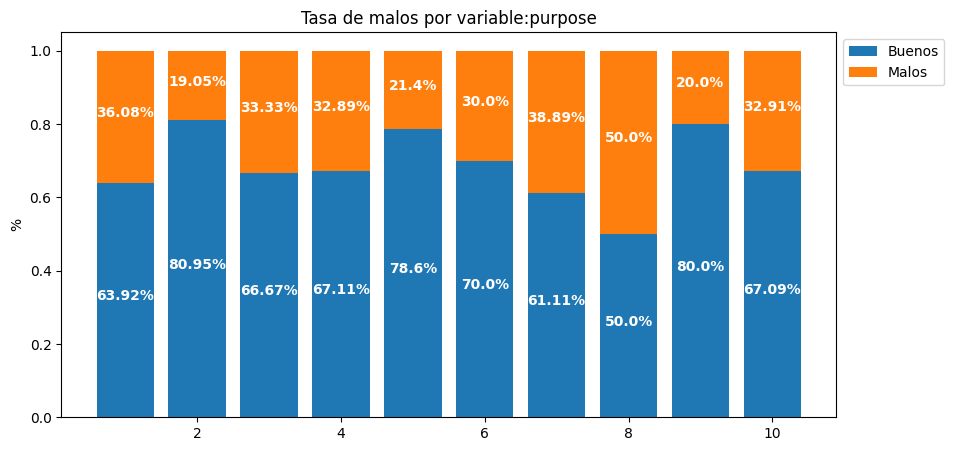

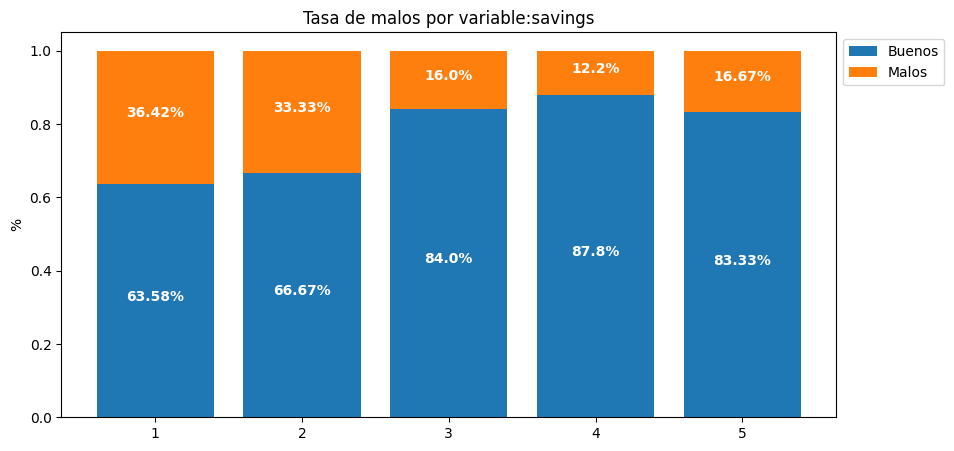

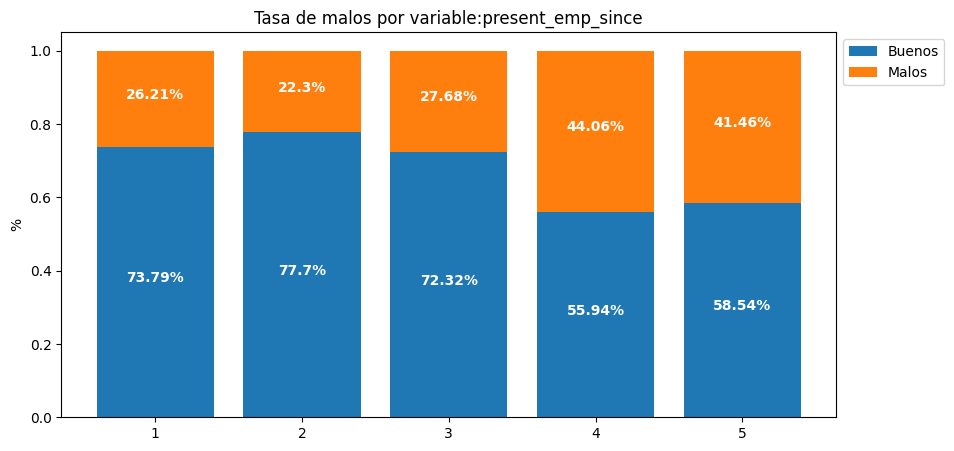

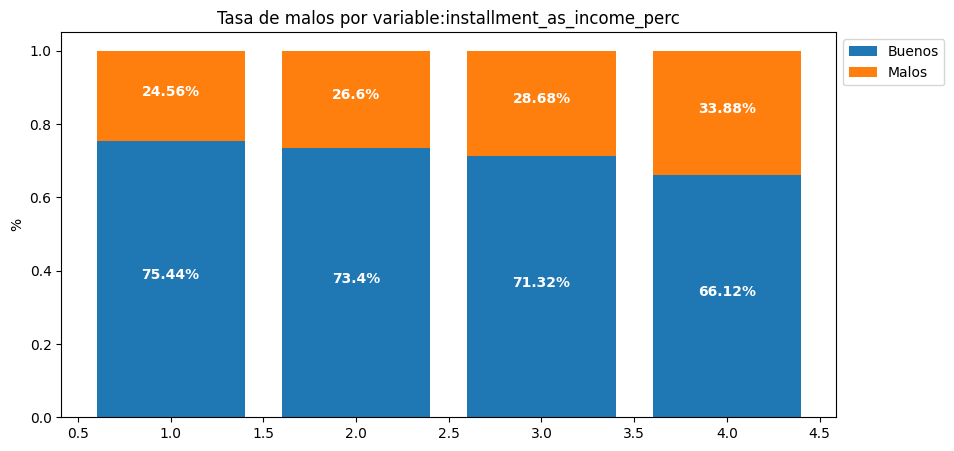

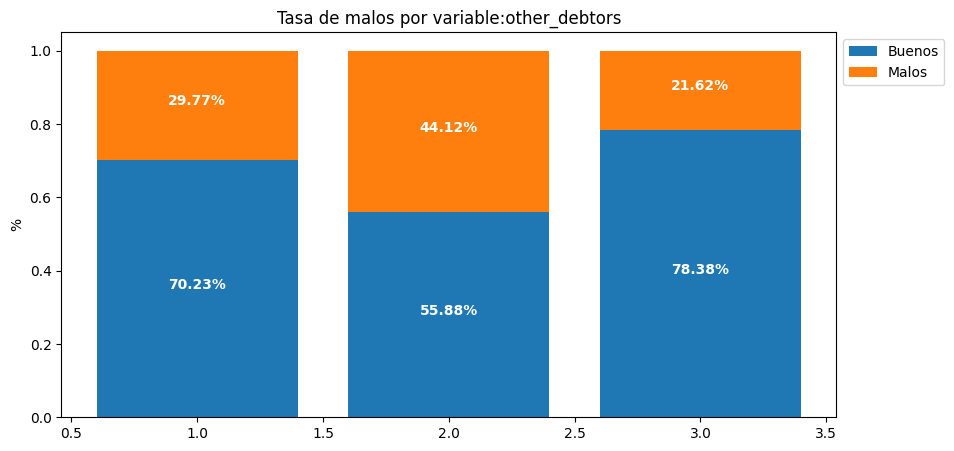

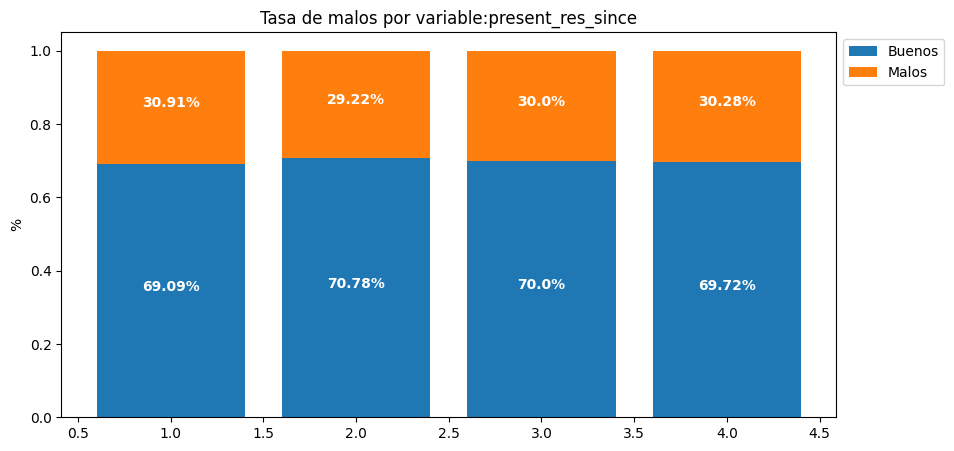

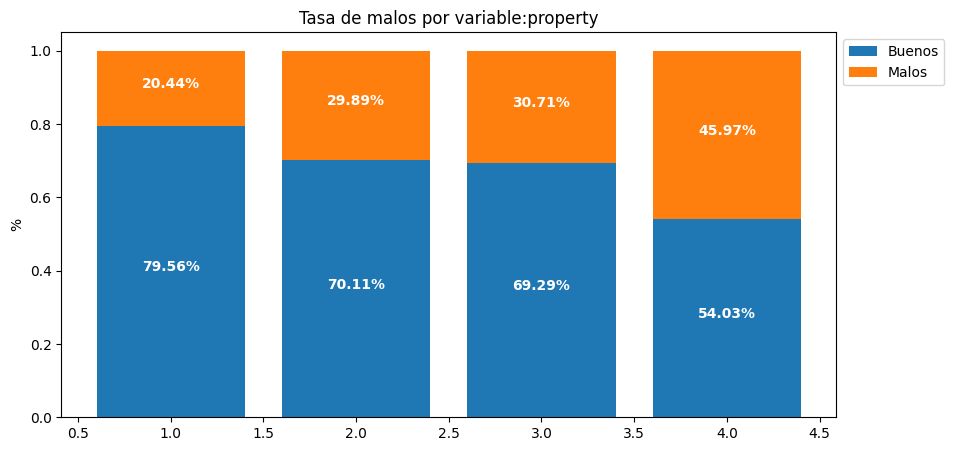

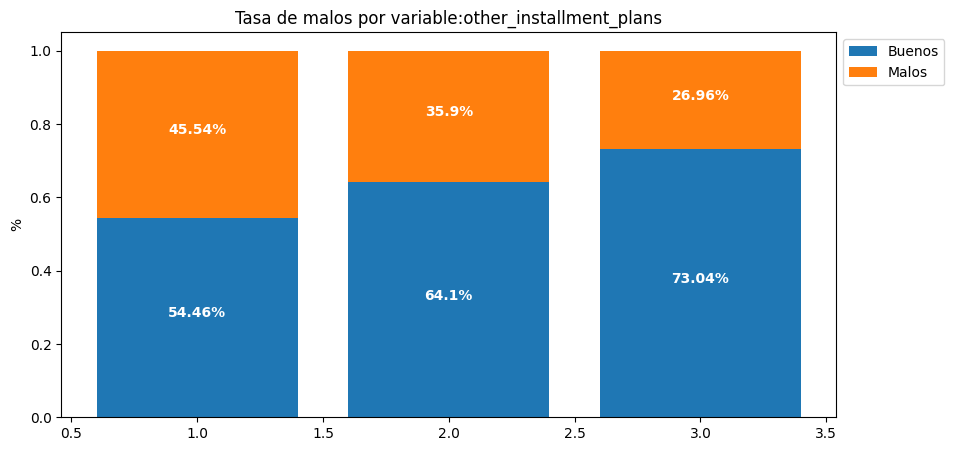

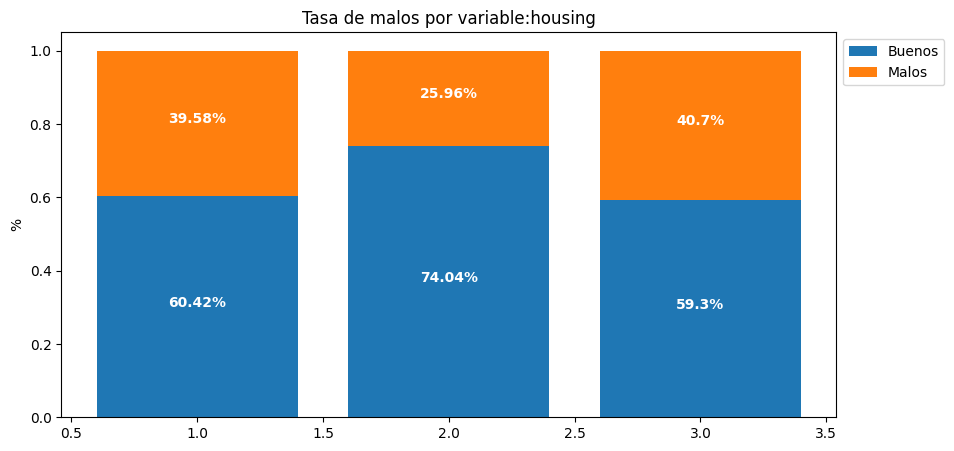

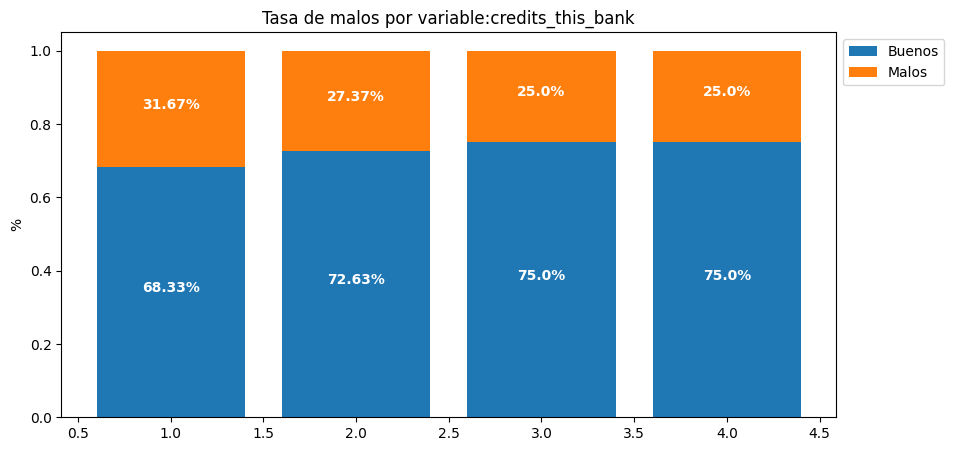

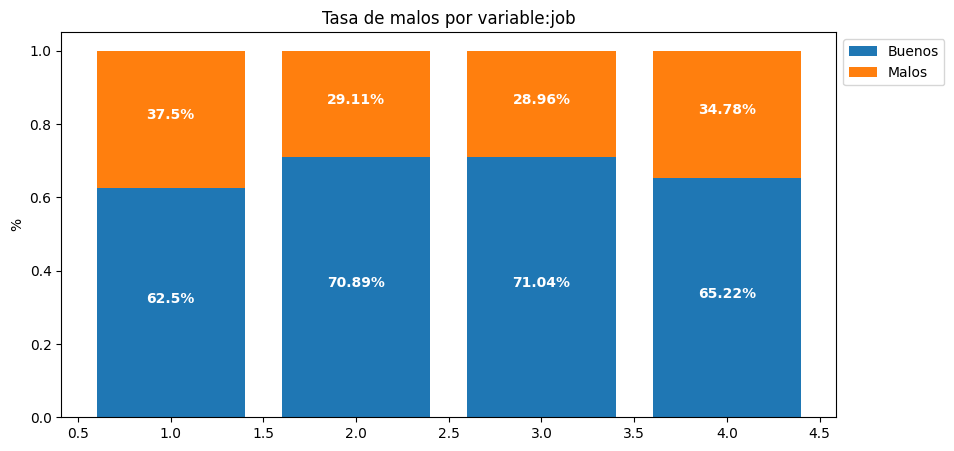

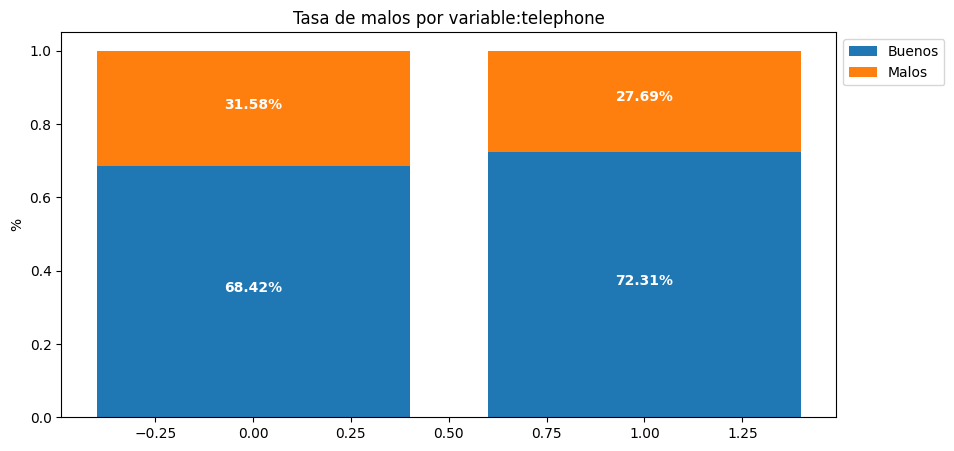

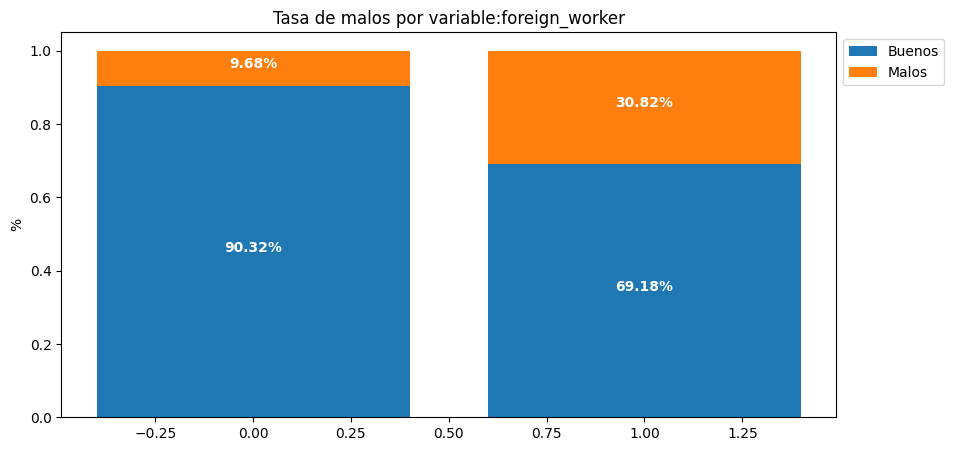

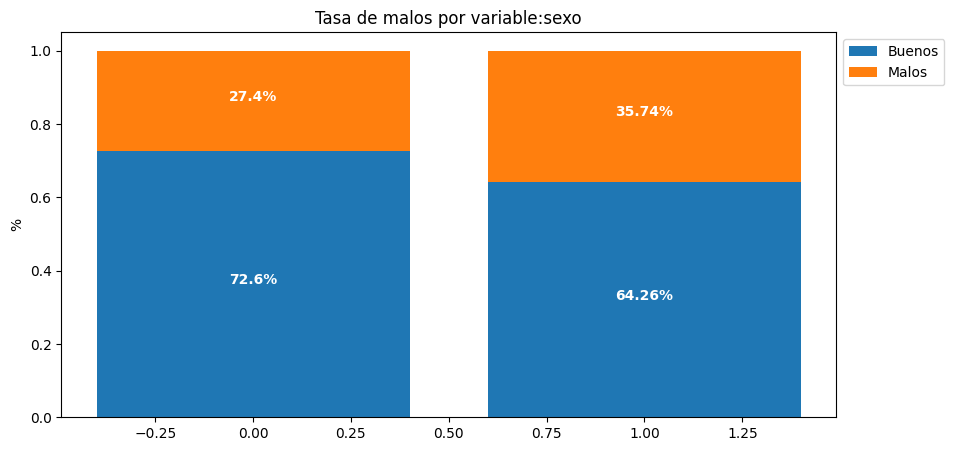

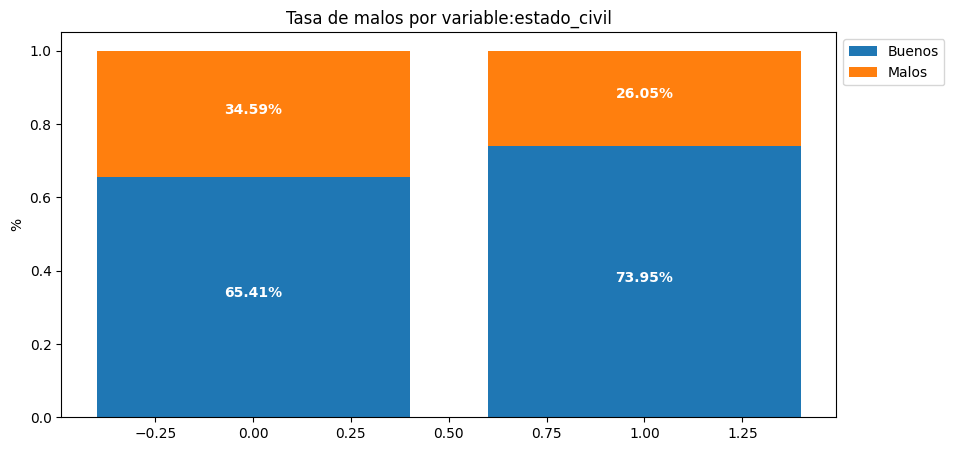

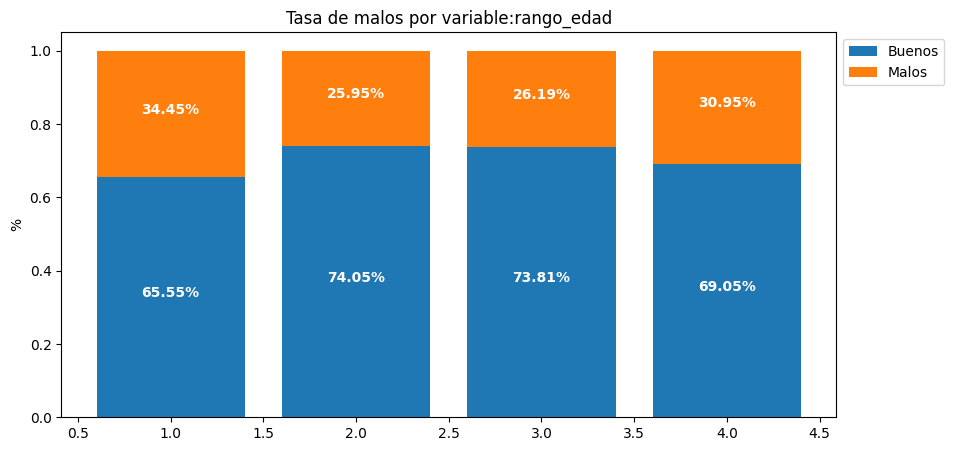

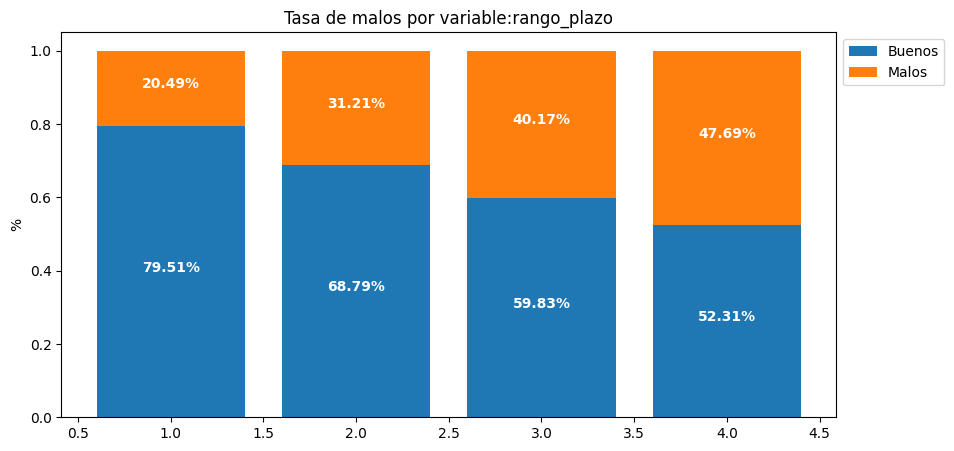

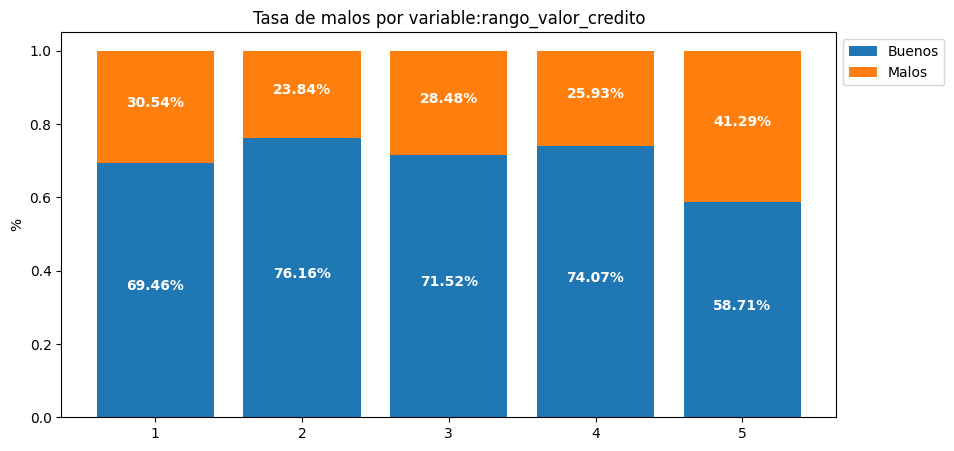

In [58]:
# banco_df['default'] = np.where(y_train == 1, 'Malo', 'Bueno')
banco_df['default'] = y_train
for col in banco_df.drop(['default', 'age', 'duration_in_month', 'credit_amount', 'people_under_maintenance'], axis=1).columns:
    bivariate_bad_plot(banco_df, varname=col, target='default', width=10, height=5, show_text=True)

Con base en el análisis exploratorio se seleccionaron la siguientes variables para la creación del modelo
- account_check_status
- credit_history
- purpose
- savings
- present_emp_since
- other_debtors*
- property*
- other_installments_plans*
- housing*
- credit_this_bank
- foreign_worker
- rango_edad*
- rango_plazo
- rango_valor_credito*

## 4.3 Análisis Correlaciones

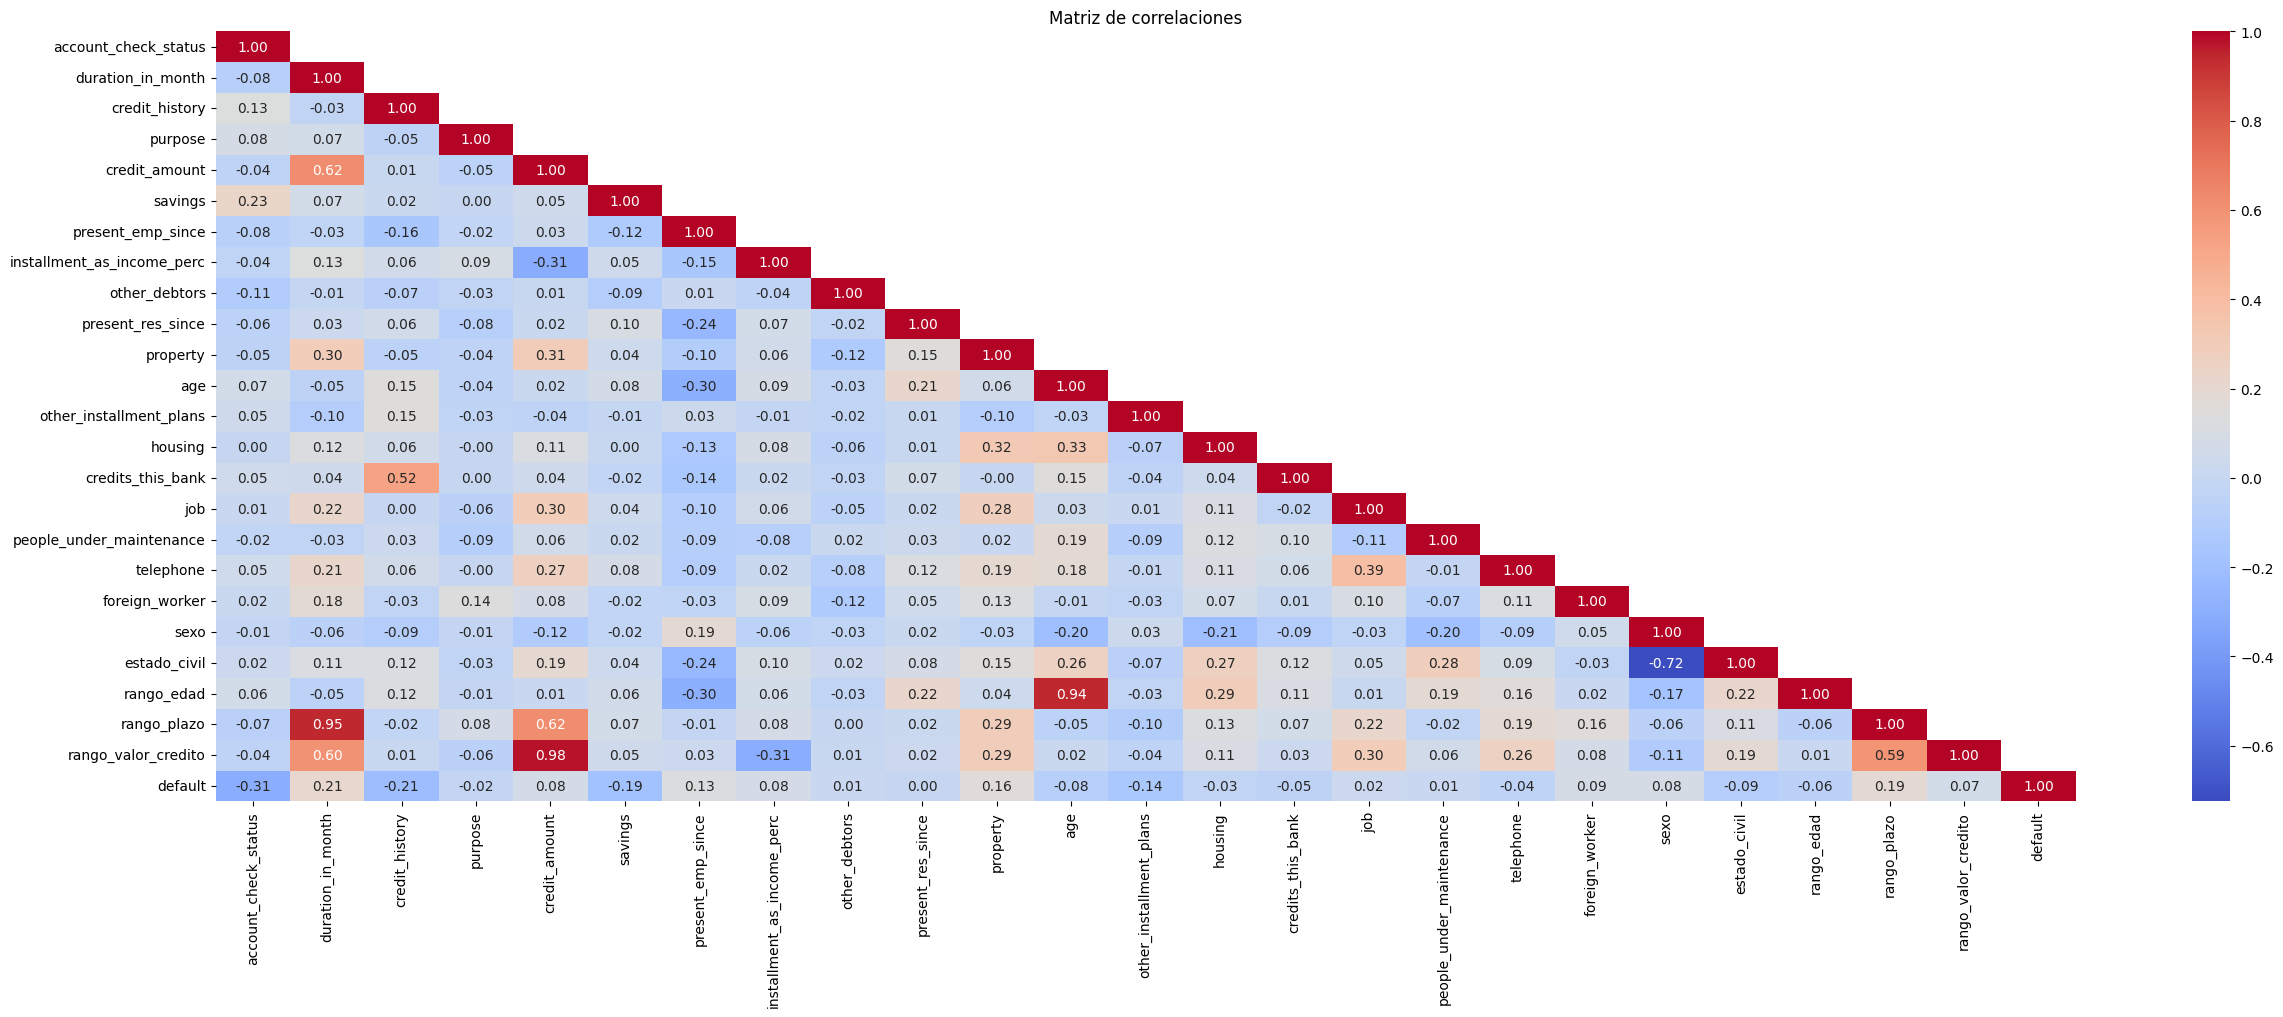

In [61]:
corr_mat = banco_df.corr(method='spearman')
lower_mat = np.triu(corr_mat, k=1)

fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(corr_mat, 
            annot=True, 
            cmap="coolwarm",
            mask=lower_mat,
            fmt=".2f",
            ax=ax)
plt.title("Matriz de correlaciones")
plt.show()

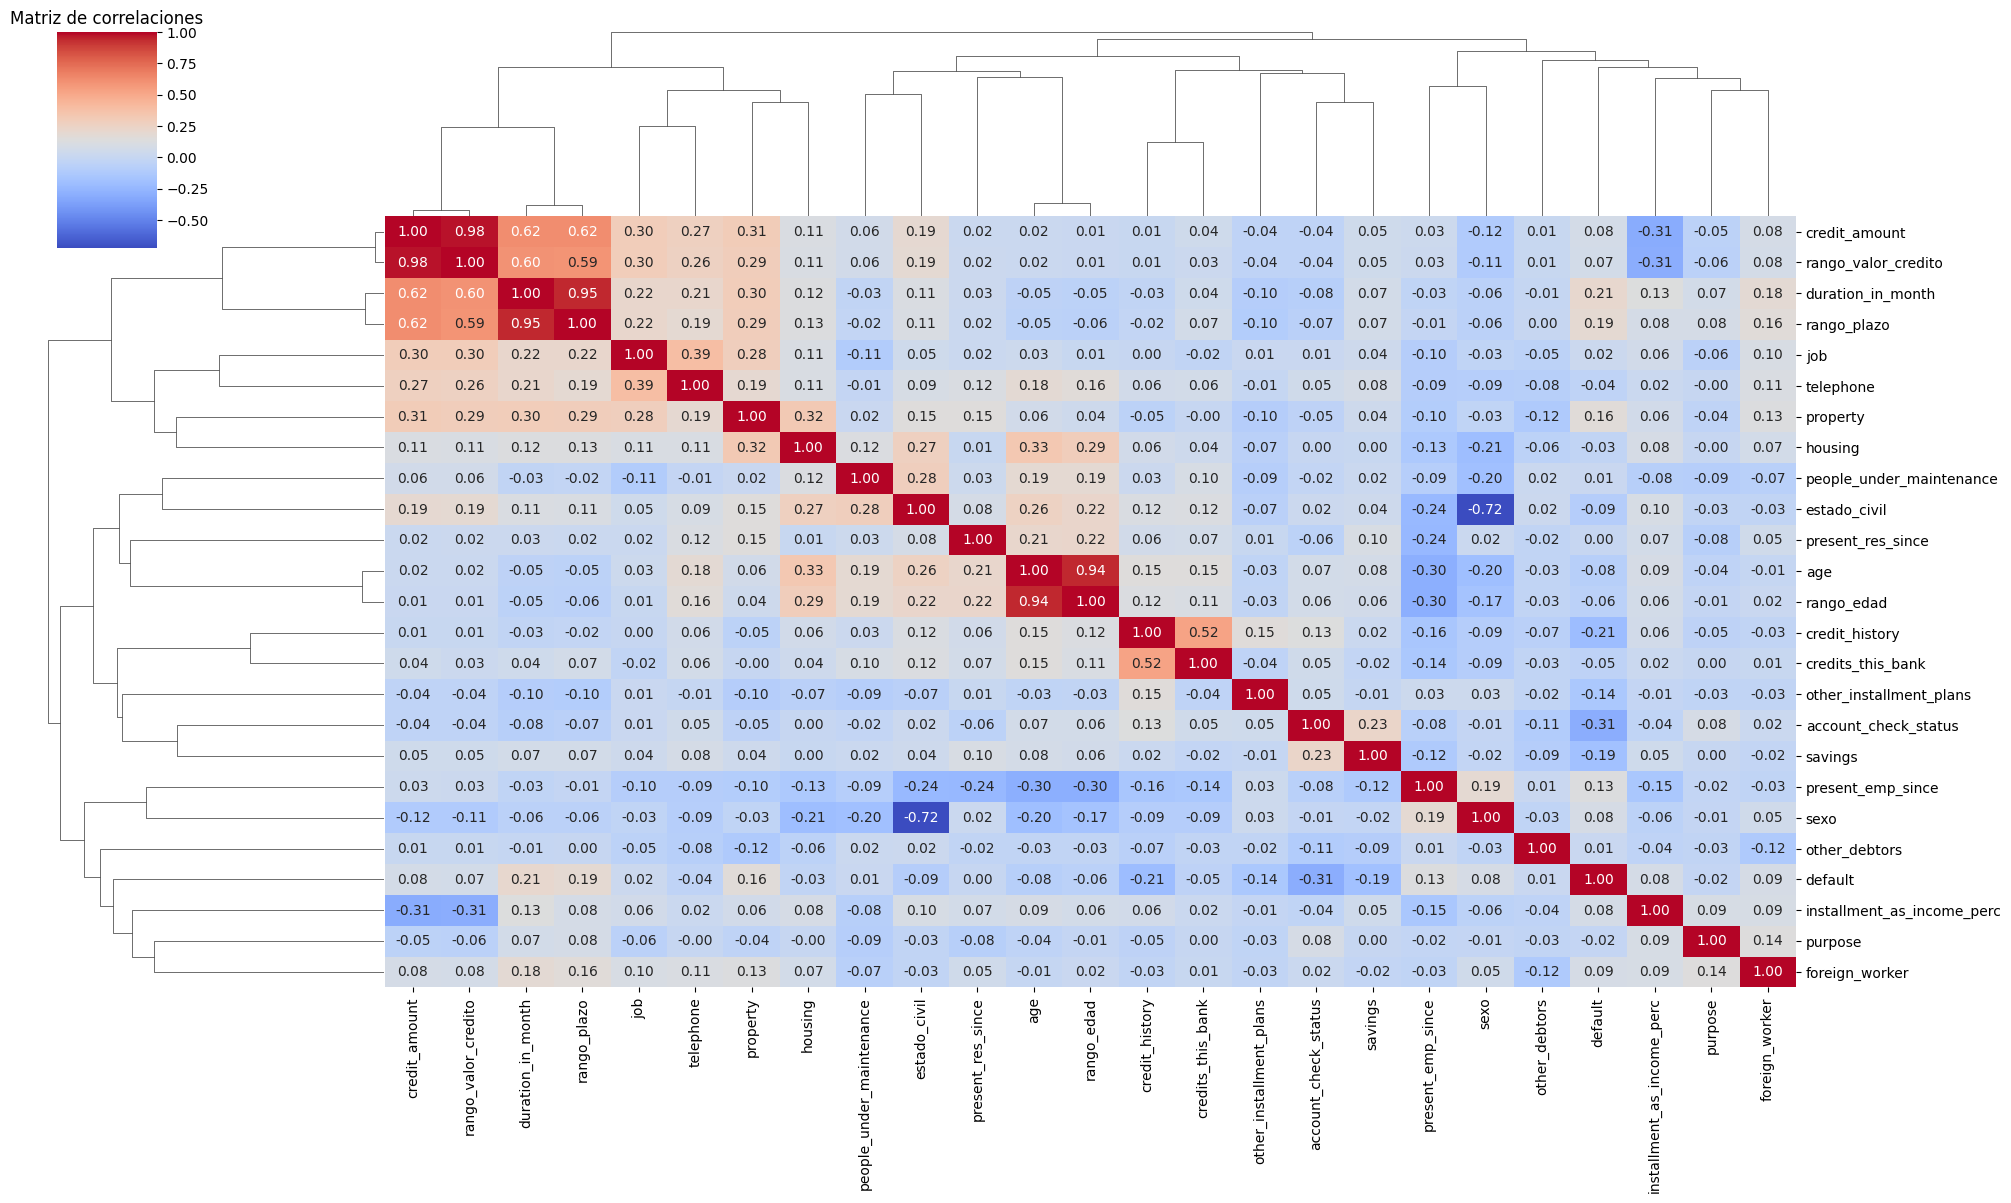

In [62]:
corr_mat = banco_df.corr(method='spearman')
lower_mat = np.triu(corr_mat, k=1)

sns.clustermap(corr_mat, annot=True, cmap="coolwarm", figsize=(20, 12), fmt=".2f")
plt.title("Matriz de correlaciones")
plt.show()

# 6. Modelamiento
---

## 6.1 Modelos Base

In [200]:
X_train = data_preprocessing(X_train)
X_train = feature_engineering(X_train, drop_column=True)

X_test = data_preprocessing(X_test)
X_test = feature_engineering(X_test, drop_column=True)

In [102]:
def crear_modelos(modelos, nombres, **kargs):
    results = {}
    models = modelos
    models_trained = []
    nombres = nombres
    precision = []
    recall = []
    f1_score_ = []
    accuracy = []
    auc = []
    gini = []
    ks = []

    for model in models:
        model.fit(X_train, y_train) # Entrena el modelo
        models_trained.append(model)
        y_pred = model.predict(X_test) # Predecir
        # Metricas
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1_score_.append(f1_score(y_test, y_pred))
        accuracy.append(accuracy_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, y_pred))
        
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        ks.append(np.max(abs(fpr - tpr)))
        gini.append(2 * roc_auc_score(y_test, y_pred) - 1)
        
    results['Algoritmo'] = nombres
    results['Modelo'] = models_trained
    results['Precision'] = precision
    results['Recall'] = recall
    results['F1-score'] = f1_score_
    results['Accuracy'] = accuracy
    results['ROC-AUC'] = auc
    results['KS'] = ks
    results['Gini'] = gini
    
    return results


In [66]:
models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB()]
nombres = ['RL', 'DT', 'RF', 'NB']
results = crear_modelos(modelos=models, nombres=nombres)
for i, model in enumerate(results['Algoritmo']):
    print(f"Modelo: {model}")
    print(f"Accuracy: {results['Accuracy'][i]}")
    print(f"Precisión: {results['Precision'][i]}")
    print(f"Recall: {results['Recall'][i]}")
    print(f"F1-score: {results['F1-score'][i]}")
    print(f"AUC-ROC: {results['ROC-AUC'][i]}")
    print(f"KS: {results['KS'][i]}")
    print(f"Gini: {results['Gini'][i]}\n")

Modelo: RL
Accuracy: 0.735
Precisión: 0.5813953488372093
Recall: 0.4166666666666667
F1-score: 0.4854368932038835
AUC-ROC: 0.6440476190476191
KS: 0.2880952380952381
Gini: 0.2880952380952382

Modelo: DT
Accuracy: 0.69
Precisión: 0.48484848484848486
Recall: 0.5333333333333333
F1-score: 0.507936507936508
AUC-ROC: 0.6452380952380952
KS: 0.29047619047619044
Gini: 0.29047619047619033

Modelo: RF
Accuracy: 0.785
Precisión: 0.7297297297297297
Recall: 0.45
F1-score: 0.556701030927835
AUC-ROC: 0.6892857142857143
KS: 0.37857142857142856
Gini: 0.37857142857142856

Modelo: NB
Accuracy: 0.7
Precisión: 0.5
Recall: 0.6166666666666667
F1-score: 0.5522388059701493
AUC-ROC: 0.6761904761904762
KS: 0.3523809523809524
Gini: 0.35238095238095246



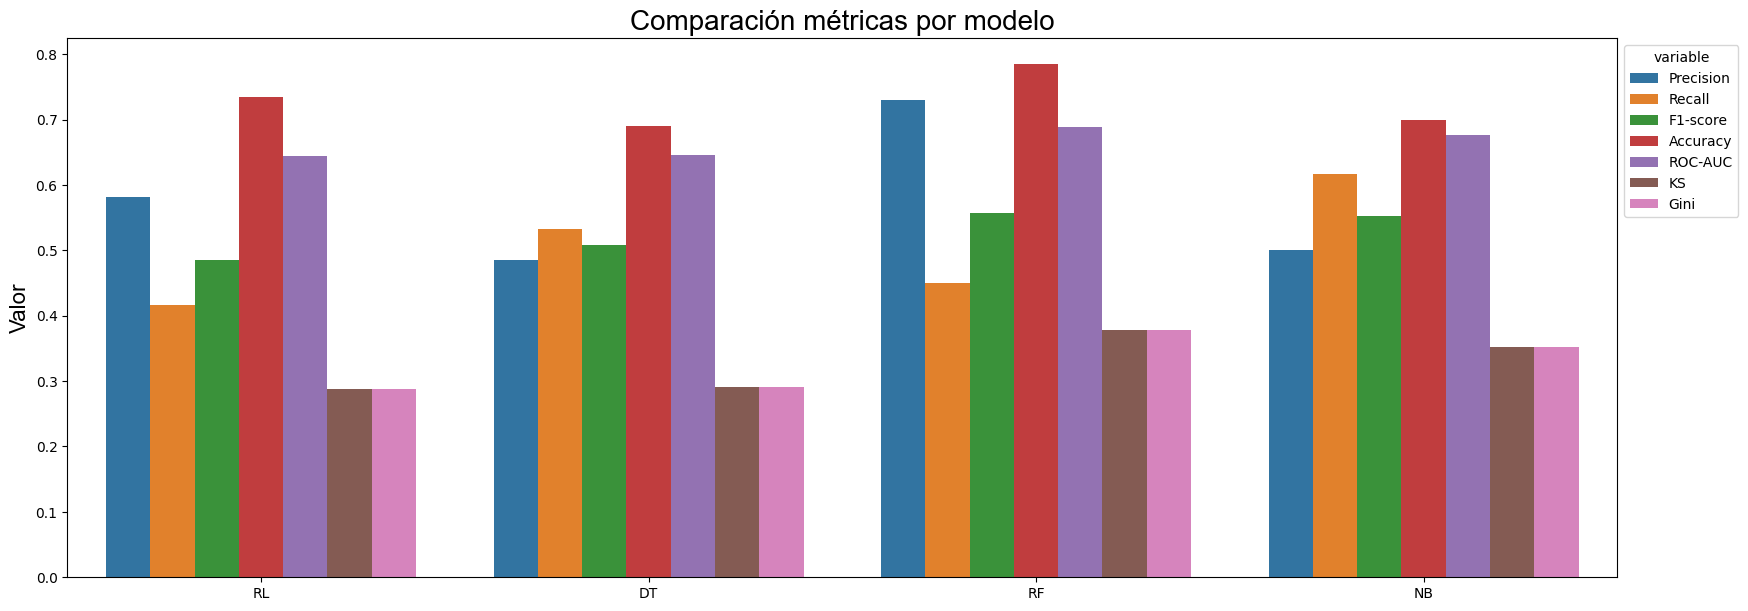

In [67]:
results_df = pd.DataFrame(results)
results_df = results_df.drop('Modelo', axis=1)

results_df = results_df.melt(
    id_vars=['Algoritmo']
)

fig, ax = plt.subplots(figsize=(20, 7))
g = sns.barplot(data=results_df, hue='variable', x='Algoritmo', y='value', ax=ax)
sns.move_legend(g, "upper left", bbox_to_anchor=(1,1))
ax.set_title("Comparación métricas por modelo", fontdict={'fontname':'Arial', 'fontsize':20})
ax.set_ylabel("Valor", fontdict={'fontname':'Arial', 'fontsize': 16})
ax.set_xlabel(None, fontdict={'fontname':'Arial', 'fontsize': 16})
plt.show()

In [68]:
pd.DataFrame(results).drop('Modelo', axis=1).set_index('Algoritmo').style.highlight_max(color='purple', axis=0)

,Precision,Recall,F1-score,Accuracy,ROC-AUC,KS,Gini
Algoritmo,,,,,,,
RL,0.581395,0.416667,0.485437,0.735000,0.644048,0.288095,0.288095
DT,0.484848,0.533333,0.507937,0.690000,0.645238,0.290476,0.290476
RF,0.729730,0.450000,0.556701,0.785000,0.689286,0.378571,0.378571
NB,0.500000,0.616667,0.552239,0.700000,0.676190,0.352381,0.352381


Aunque las resultados del Random Forest son ligeramente superiores al Naive Bayes, se observa que la diferencia no el muy grande; y teniendo en cuenta la complejidad de los modelos se decide tomar como modelo base el **Gausian Naive Bayes.**

## 6.2 Seleccion de variables

### 6.2.1 Análisis de Componentes Principales (PCA)

In [69]:
def biplot(data, loadings, index1, index2, target_var, labels=None):
    """
    Función para graficar los componentes principales
    """
    plt.figure(figsize=(12, 7))
    xs = data[:,index1]
    ys = data[:,index2]
    n=loadings.shape[0]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley, c=target_var, alpha=0.8)
    for i in range(n):
        plt.arrow(0, 0, loadings[i,index1], loadings[i,index2], color='r', lw=2)
        if labels is None:
            plt.text(loadings[i,index1]* 1.15, loadings[i,index2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center', weight='bold', size=10)
        else:
            plt.text(loadings[i,index1]* 1.15, loadings[i,index2] * 1.15, labels[i], color='r', ha='center', va='center', weight='bold', size=10)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(index1))
    plt.ylabel("PC{}".format(index2))
    plt.axvline(x=0, color='black', linestyle='--')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.grid()

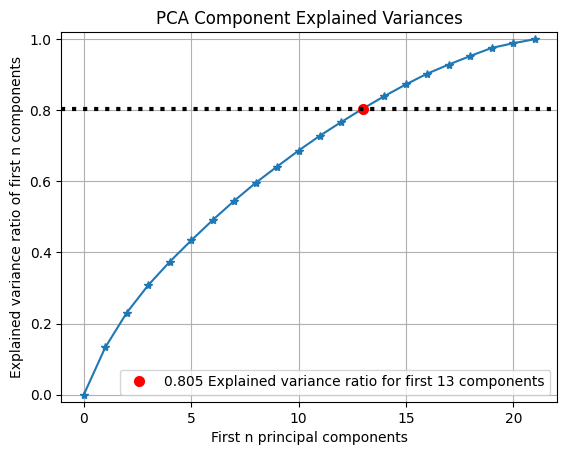

In [70]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train.values)
scaled_data = pd.DataFrame(scaled_data,
                           columns=X_train.columns,
                           index=X_train.index
                           )

pca = PCA(random_state=42)
pca.fit(scaled_data)
skplt.decomposition.plot_pca_component_variance(pca, target_explained_variance=0.775)
plt.show()

In [ ]:
pca = PCA(n_components=12, random_state=42)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

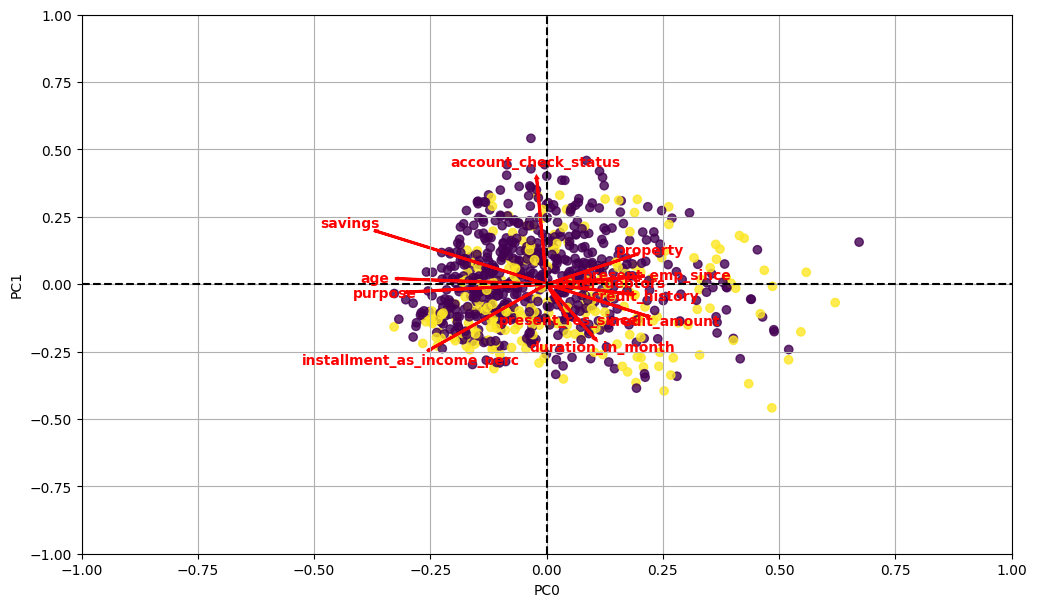

In [ ]:
biplot(data=pca_data, loadings=pca.components_, index1=0, index2=1, target_var=[*y_train.values], labels=scaled_data.columns.tolist())

### 6.2.2 Regresión Lasso

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


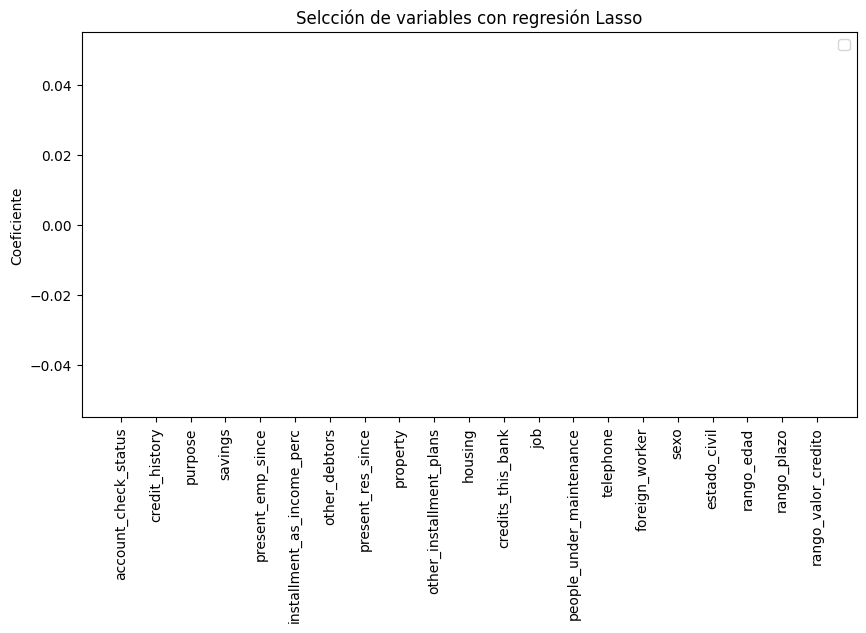

In [71]:
lasso = Lasso()
lasso.fit(X_train, y_train)

coeficientes = [*lasso.coef_]
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(np.arange(len(coeficientes)), coeficientes, width=0.25)
ax.set_xticks(np.arange(len(coeficientes)))
ax.set_xticklabels(X_train.columns, rotation=90)
ax.set_ylabel("Coeficiente")
ax.set_title("Selcción de variables con regresión Lasso")
ax.legend()
plt.show()


In [76]:
"""
Se entrena el modelo base seleccionado con cada una de las variables del dataset 
de entrenamiento. Luego se calculan las métricas con el objetivo de evaluar
cuales métricas por si solas tienen capacidad de predicción de la variable 
objetivo
"""
metricas_df = pd.DataFrame()
for col in X_train.columns:
    model = GaussianNB()
    model.fit(X_train[[col]], y_train)
    y_pred = model.predict(X_test[[col]]) # Predecir
    # Metricas
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_score_ = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    ks = np.max(abs(fpr - tpr))
    gini = 2 * roc_auc_score(y_test, y_pred) - 1
    
    data = {
        'variable': [col],
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1_score': [f1_score_],
        'roc_auc': [auc],
        'ks':[ks],
        'gini':[gini]
    }
    
    temp_df = pd.DataFrame(data)
    metricas_df = pd.concat([metricas_df, temp_df], axis=0, ignore_index=False)

metricas_df = metricas_df.reset_index(drop=True)

In [77]:
(metricas_df
 .sort_values(by=['roc_auc', 'f1_score'], ascending=[False, False])
 .reset_index(drop=True)
 .set_index('variable')
 .style
 .highlight_max(color='purple', axis= 0)
)

,accuracy,precision,recall,f1_score,roc_auc,ks,gini
variable,,,,,,,
account_check_status,0.725000,0.545455,0.500000,0.521739,0.660714,0.321429,0.321429
rango_plazo,0.730000,0.636364,0.233333,0.341463,0.588095,0.176190,0.176190
credit_history,0.715000,0.666667,0.100000,0.173913,0.539286,0.078571,0.078571
purpose,0.700000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
savings,0.700000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
present_emp_since,0.700000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
installment_as_income_perc,0.700000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
other_debtors,0.700000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
present_res_since,0.700000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000


Con base en el análisis exploratorio se seleccionaron la siguientes variables para la creación del modelo
- account_check_status
- credit_history
- purpose
- savings
- present_emp_since
- other_debtors*
- property*
- other_installments_plans
- housing*
- credit_this_bank
- foreign_worker
- rango_edad*
- rango_plazo
- rango_valor_credito*

(*) La variable por si sola no muestra un potencial para segmentar el nivel de default. Sin embargo, por conocimiento de negocio se decide utilizarla para la creación del modelo

## 6.3 Preparación de los datos de entrenamiento y prueba

In [202]:
# Variables seleccionadas
cols = ['account_check_status', 'credit_history', 'purpose', 'savings',
        'present_emp_since', 'other_debtors', 'property', 'other_installment_plans',
        'housing', 'credits_this_bank', 'foreign_worker', 'rango_edad',
        'rango_plazo', 'rango_valor_credito']

# Datos de entrenamiento
X_train = X_train.loc[:, cols]

# Datos de prueba
X_test = X_test.loc[:, cols]

## 6.3 Optimización de hiperparámetros

### 6.3.1 Pipeline de procesamiento

In [81]:
nominal_vars = ['credit_history', 'purpose', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'foreign_worker']
ordinal_vars = ['account_check_status', 'rango_edad', 'rango_plazo', 'rango_valor_credito', 'savings', 'present_emp_since', 'credits_this_bank']

nominal_transformer = Pipeline(
    steps=[
        ('impute', KNNImputer(n_neighbors=5)),
        ('ohe', OneHotEncoder())
    ]
)

ordinal_transformer = Pipeline(
    steps=[
        ('impute', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler()),
        ('pca', PCA())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_vars),
        ('ordinal', ordinal_transformer, ordinal_vars)
    ],
    remainder='passthrough'
)

In [181]:
def add_model(data_pipeline, model, smote=False) -> Pipeline:
    """Funcion para crear pipeline de procesamiento completo
    
        Args
        ----
        data_pipeline: sklearn.pipeline
        model: sklearn model
        smote: boolean, default False
    """
    if smote:
        whole_pipeline = imbPipeline([
            ("data_pipeline", data_pipeline),
            ("model", model)
        ])
    else:
        whole_pipeline = Pipeline([
            ("data_pipeline", data_pipeline),
            ("model", model)
            ])
    return whole_pipeline

### 6.3.2 Optimización de hiperparámetros

In [83]:
# Regresión Logística
rl_param_grid = [
    {'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
     'model__penalty': ['l1', 'l2', 'elasticnet', None], 
     'model__solver': ['saga'], 
     'model__class_weight': [None, {1: 40}, {1: 50}, 'balanced'],
     'data_pipeline__ordinal__pca__n_components': [2, 5, 10, 14]
     },
    {'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
     'model__penalty': ['l1', 'l2'], 
     'model__solver': ['liblinear'], 
     'model__class_weight': [None, {1: 40}, {1: 50}, 'balanced'],
     'data_pipeline__ordinal__pca__n_components': [2, 5, 10, 14]
     }
]

rl = LogisticRegression()
pipeline = add_model(preprocessor, rl)

rl_gs = GridSearchCV(estimator=pipeline,
                  param_grid=rl_param_grid,
                  scoring='roc_auc',
                  cv=5
                  )

# Entrenar el modelo
rl_gs.fit(X_train, y_train)

# Metricas
rl_scores = cross_val_score(rl_gs, X_train, y_train, scoring='roc_auc', cv=5)

In [84]:
print(f"CV ROC-AUC: {np.mean(rl_scores):.3f} +/- {np.std(rl_scores)}")

CV ROC-AUC: 0.712 +/- 0.11108926225224477


In [85]:
best_rl_params = rl_gs.best_params_
best_rl_score = rl_gs.best_score_
best_rl = rl_gs.best_estimator_
best_rl

Pipeline(steps=[('data_pipeline',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer()),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['credit_history', 'purpose',
                                                   'other_debtors', 'property',
                                                   'other_installment_plans',
                                                   'housing',
                                                   'foreign_worker']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  ['account_check_status',
                                                   'rango_edad', 'rango_plazo',
                                                   'rango_valor_credito',
                                                   'savings',
                                                   'present_emp_since',
                                                   'credits_this_bank'])])),
                ('model', LogisticRegression(C=0.1, solver='saga'))])

In [95]:
# Arbol de decisión
dt_param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__class_weight': [None, {1: 40}, {1: 50}, 'balanced'],
    'data_pipeline__ordinal__pca__n_components': [2, 5, 10, 14]
}

tree = DecisionTreeClassifier()
pipeline = add_model(preprocessor, tree)

tree_gs = GridSearchCV(estimator=pipeline,
                  param_grid=dt_param_grid,
                  scoring='roc_auc',
                  cv=5
                  )

# Entrenar el modelo
tree_gs.fit(X_train, y_train)

# Metricas
tree_scores = cross_val_score(tree_gs, X_train, y_train, scoring='roc_auc', cv=5)

In [96]:
print(f"CV ROC-AUC: {np.mean(tree_scores):.3f} +/- {np.std(tree_scores)}")

CV ROC-AUC: 0.629 +/- 0.045171894786605674


In [97]:
best_tree_params = tree_gs.best_params_
best_tree_score = tree_gs.best_score_
best_tree = tree_gs.best_estimator_
best_tree

Pipeline(steps=[('data_pipeline',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer()),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['credit_history', 'purpose',
                                                   'other_debtors', 'property',
                                                   'other_installment_plans',
                                                   'housing',
                                                   'foreign_worker']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  ['account_check_status',
                                                   'rango_edad', 'rango_plazo',
                                                   'rango_valor_credito',
                                                   'savings',
                                                   'present_emp_since',
                                                   'credits_this_bank'])])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=20,
                                        max_features='sqrt', min_samples_leaf=4,
                                        min_samples_split=10))])

In [98]:
# Random Forest
rf_param_grid = {
    'model__n_estimators': [100, 200, 500],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__class_weight': [None, 'balanced'],
    'data_pipeline__ordinal__pca__n_components': [2, 5, 10, 14]
}

rf = RandomForestClassifier()
pipeline = add_model(preprocessor, rf)

rf_gs = GridSearchCV(estimator=pipeline,
                  param_grid=rf_param_grid,
                  scoring='roc_auc',
                  cv=5
                  )

# Entrenar el modelo
rf_gs.fit(X_train, y_train)

# Metricas
rf_scores = cross_val_score(rf_gs, X_train, y_train, scoring='roc_auc', cv=5)

In [99]:
print(f"CV ROC-AUC: {np.mean(rf_scores):.3f} +/- {np.std(rf_scores)}")

CV ROC-AUC: 0.755 +/- 0.026443906677368862


In [100]:
best_rf_params = rf_gs.best_params_
best_rf_score = rf_gs.best_score_
best_rf = rf_gs.best_estimator_
best_rf

Pipeline(steps=[('data_pipeline',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer()),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['credit_history', 'purpose',
                                                   'other_debtors', 'property',
                                                   'other_installment_plans',
                                                   'housing',
                                                   'foreign_worker']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  ['account_check_status',
                                                   'rango_edad', 'rango_plazo',
                                                   'rango_valor_credito',
                                                   'savings',
                                                   'present_emp_since',
                                                   'credits_this_bank'])])),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_split=10))])

In [88]:
# Naive Bayes
nb_param_grid = {
    'model__priors': [None],
    'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
    'data_pipeline__ordinal__pca__n_components': [2, 5, 10, 14]
}

nb = GaussianNB()
pipeline = add_model(preprocessor, nb)

nb_gs = GridSearchCV(estimator=pipeline,
                  param_grid=nb_param_grid,
                  scoring='roc_auc',
                  cv=5
                  )

# Entrenar el modelo
nb_gs.fit(X_train, y_train)

# Metricas
nb_scores = cross_val_score(nb_gs, X_train, y_train, scoring='roc_auc', cv=5)

In [94]:
print(f"CV ROC-AUC: {np.mean(nb_scores, where=[True,True,True,False,True]):.3f} +/- {np.std(nb_scores, where=[True,True,True,False,True])}")

CV ROC-AUC: 0.683 +/- 0.04268788312827058


In [90]:
best_nb_params = nb_gs.best_params_
best_nb_score = nb_gs.best_score_
best_nb = nb_gs.best_estimator_
best_nb

Pipeline(steps=[('data_pipeline',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer()),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['credit_history', 'purpose',
                                                   'other_debtors', 'property',
                                                   'other_installment_plans',
                                                   'housing',
                                                   'foreign_worker']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  ['account_check_status',
                                                   'rango_edad', 'rango_plazo',
                                                   'rango_valor_credito',
                                                   'savings',
                                                   'present_emp_since',
                                                   'credits_this_bank'])])),
                ('model', GaussianNB())])

### 6.3.3 Comparación y selección del modelo

In [161]:
nominal_vars = ['credit_history', 'purpose', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'foreign_worker']
ordinal_vars = ['account_check_status', 'rango_edad', 'rango_plazo', 'rango_valor_credito', 'savings', 'present_emp_since', 'credits_this_bank']

nominal_transformer = Pipeline(
    steps=[
        ('impute', KNNImputer(n_neighbors=5)),
        ('ohe', OneHotEncoder())
    ]
)

ordinal_transformer = Pipeline(
    steps=[
        ('impute', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=5))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_vars),
        ('ordinal', ordinal_transformer, ordinal_vars)
    ],
    remainder='passthrough'
)

In [165]:
# Aplicando preprocesamiento
# rl = add_model(preprocessor, LogisticRegression(C=0.1, penalty='l2', solver='saga', class_weight=None))
# tree = add_model(preprocessor, DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=20, max_features='sqrt', min_samples_split=4, min_samples_leaf=10))
# rf = add_model(preprocessor, RandomForestClassifier(class_weight=None, criterion='gini', max_depth=10, min_samples_split=10, n_estimators=100))
# nb = add_model(preprocessor, GaussianNB(var_smoothing=1e-09))

# Con preprocesamiento y con hiperparametros default
rl = add_model(preprocessor, LogisticRegression())
tree = add_model(preprocessor, DecisionTreeClassifier())
rf = add_model(preprocessor, RandomForestClassifier())
nb = add_model(preprocessor, GaussianNB())

models = [rl, tree, rf, nb]
nombres = ['RL', 'DT', 'RF', 'NB']
results = crear_modelos(modelos=models, nombres=nombres)
for i, model in enumerate(results['Algoritmo']):
    print(f"Modelo: {model}")
    print(f"Accuracy: {results['Accuracy'][i]}")
    print(f"Precisión: {results['Precision'][i]}")
    print(f"Recall: {results['Recall'][i]}")
    print(f"F1-score: {results['F1-score'][i]}")
    print(f"AUC-ROC: {results['ROC-AUC'][i]}")
    print(f"KS: {results['KS'][i]}")
    print(f"Gini: {results['Gini'][i]}\n")

Modelo: RL
Accuracy: 0.745
Precisión: 0.6097560975609756
Recall: 0.4166666666666667
F1-score: 0.4950495049504951
AUC-ROC: 0.6511904761904762
KS: 0.3023809523809524
Gini: 0.3023809523809524

Modelo: DT
Accuracy: 0.66
Precisión: 0.4375
Recall: 0.4666666666666667
F1-score: 0.45161290322580644
AUC-ROC: 0.6047619047619048
KS: 0.20952380952380956
Gini: 0.20952380952380967

Modelo: RF
Accuracy: 0.775
Precisión: 0.6923076923076923
Recall: 0.45
F1-score: 0.5454545454545455
AUC-ROC: 0.682142857142857
KS: 0.3642857142857143
Gini: 0.3642857142857141

Modelo: NB
Accuracy: 0.675
Precisión: 0.4647887323943662
Recall: 0.55
F1-score: 0.5038167938931297
AUC-ROC: 0.6392857142857143
KS: 0.27857142857142864
Gini: 0.2785714285714287



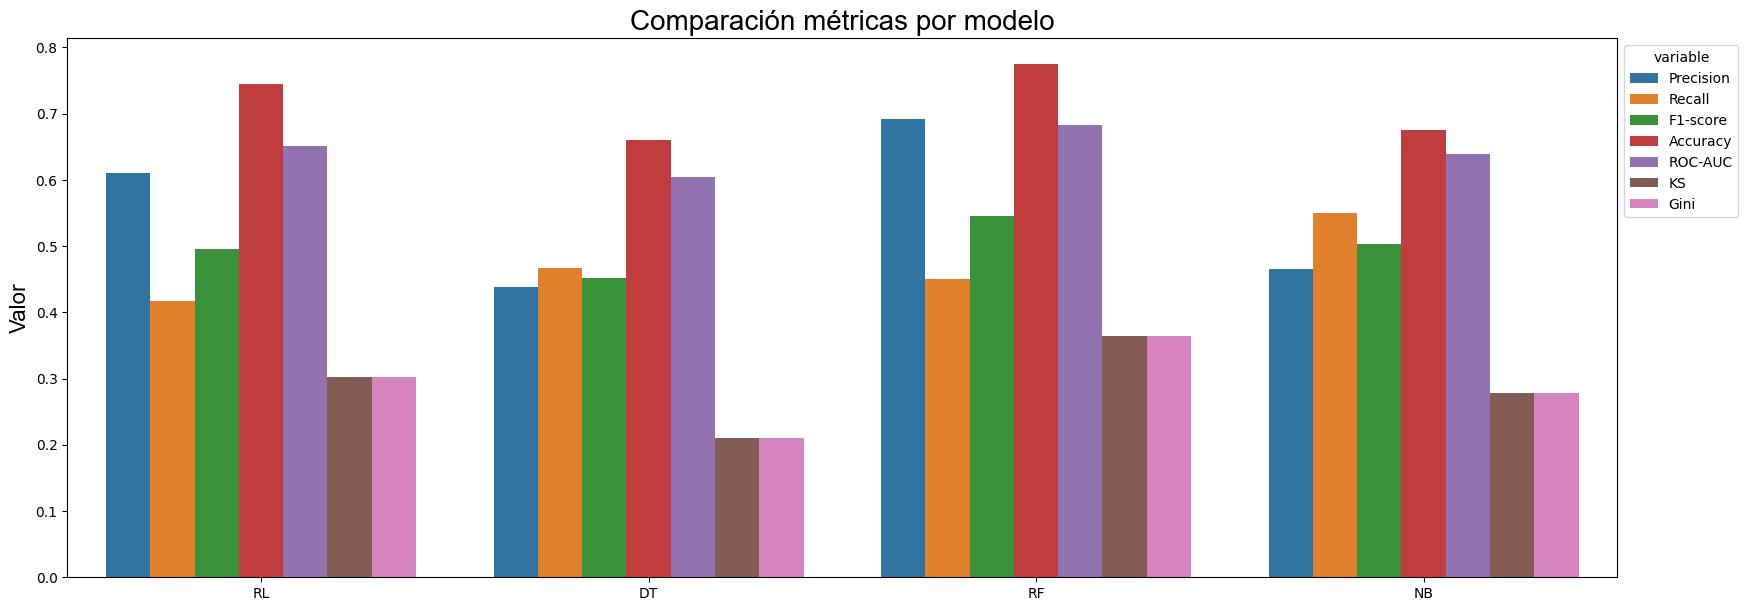

In [166]:
results_df = pd.DataFrame(results)
results_df = results_df.drop('Modelo', axis=1)

results_df = results_df.melt(
    id_vars=['Algoritmo']
)

fig, ax = plt.subplots(figsize=(20, 7))
g = sns.barplot(data=results_df, hue='variable', x='Algoritmo', y='value', ax=ax)
sns.move_legend(g, "upper left", bbox_to_anchor=(1,1))
ax.set_title("Comparación métricas por modelo", fontdict={'fontname':'Arial', 'fontsize':20})
ax.set_ylabel("Valor", fontdict={'fontname':'Arial', 'fontsize': 16})
ax.set_xlabel(None, fontdict={'fontname':'Arial', 'fontsize': 16})
plt.show()

In [164]:
# Metricas de modelos entranados con preprocesamiento e hiperparámetros ajustados
pd.DataFrame(results).drop('Modelo', axis=1).set_index('Algoritmo').style.highlight_max(color='purple', axis=0)

,Precision,Recall,F1-score,Accuracy,ROC-AUC,KS,Gini
Algoritmo,,,,,,,
RL,0.621622,0.383333,0.474227,0.745000,0.641667,0.283333,0.283333
DT,0.416667,0.583333,0.486111,0.630000,0.616667,0.233333,0.233333
RF,0.647059,0.366667,0.468085,0.750000,0.640476,0.280952,0.280952
NB,0.464789,0.550000,0.503817,0.675000,0.639286,0.278571,0.278571


In [167]:
# Metricas de modelos entranados con preprocesamiento e hiperparámetros por default
pd.DataFrame(results).drop('Modelo', axis=1).set_index('Algoritmo').style.highlight_max(color='purple', axis=0)

,Precision,Recall,F1-score,Accuracy,ROC-AUC,KS,Gini
Algoritmo,,,,,,,
RL,0.609756,0.416667,0.495050,0.745000,0.651190,0.302381,0.302381
DT,0.437500,0.466667,0.451613,0.660000,0.604762,0.209524,0.209524
RF,0.692308,0.450000,0.545455,0.775000,0.682143,0.364286,0.364286
NB,0.464789,0.550000,0.503817,0.675000,0.639286,0.278571,0.278571


Luego de realizar este el ejercicio de entrenar los modelos modificando el valor de sus hiperparámetros y comparando contra el modelo base. Para este caso, con los resultados obtenidos, se decide seleccionar el modelo creado con el algoritmo de Random Forest.

Teniendo en cuenta que en este problema se desea disminuir la tasa de falsos negativos y que la variable objetvo se encuentra desbalanceada. Se da mayor importancia a las métricas
de ROC-AUC, KS, Gini y F1-score

Al comparar los resultados se observa que el Random Forest es el que mejor se desempeña en estas métricas

### 6.3.4 Modelo Seleccionado con balanceo de datos

In [191]:
nominal_transformer = Pipeline(
    steps=[
        ('impute', KNNImputer(n_neighbors=5)),
        ('ohe', OneHotEncoder())
    ]
)

ordinal_transformer = Pipeline(
    steps=[
        ('impute', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler()),
        # ('pca', PCA(n_components=5))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_vars),
        ('ordinal', ordinal_transformer, ordinal_vars)
    ],
    remainder='passthrough'
)

smote_pipeline = imbPipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', RandomForestClassifier())
    ]
)

under_sampler_pipeline = imbPipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('smote', RandomUnderSampler(random_state=42)),
        ('model', RandomForestClassifier())
    ]
)

In [192]:
pipelines = [smote_pipeline, under_sampler_pipeline]
nombres = ['RF_SMOTE', 'RF_UNDER_SAMPLER']
results = crear_modelos(modelos=pipelines, nombres=nombres)
for i, model in enumerate(results['Algoritmo']):
    print(f"Modelo: {model}")
    print(f"Accuracy: {results['Accuracy'][i]}")
    print(f"Precisión: {results['Precision'][i]}")
    print(f"Recall: {results['Recall'][i]}")
    print(f"F1-score: {results['F1-score'][i]}")
    print(f"AUC-ROC: {results['ROC-AUC'][i]}")
    print(f"KS: {results['KS'][i]}")
    print(f"Gini: {results['Gini'][i]}\n")

Modelo: RF_SMOTE
Accuracy: 0.745
Precisión: 0.6
Recall: 0.45
F1-score: 0.5142857142857143
AUC-ROC: 0.6607142857142857
KS: 0.32142857142857145
Gini: 0.3214285714285714

Modelo: RF_UNDER_SAMPLER
Accuracy: 0.66
Precisión: 0.45652173913043476
Recall: 0.7
F1-score: 0.5526315789473684
AUC-ROC: 0.6714285714285714
KS: 0.3428571428571428
Gini: 0.34285714285714275



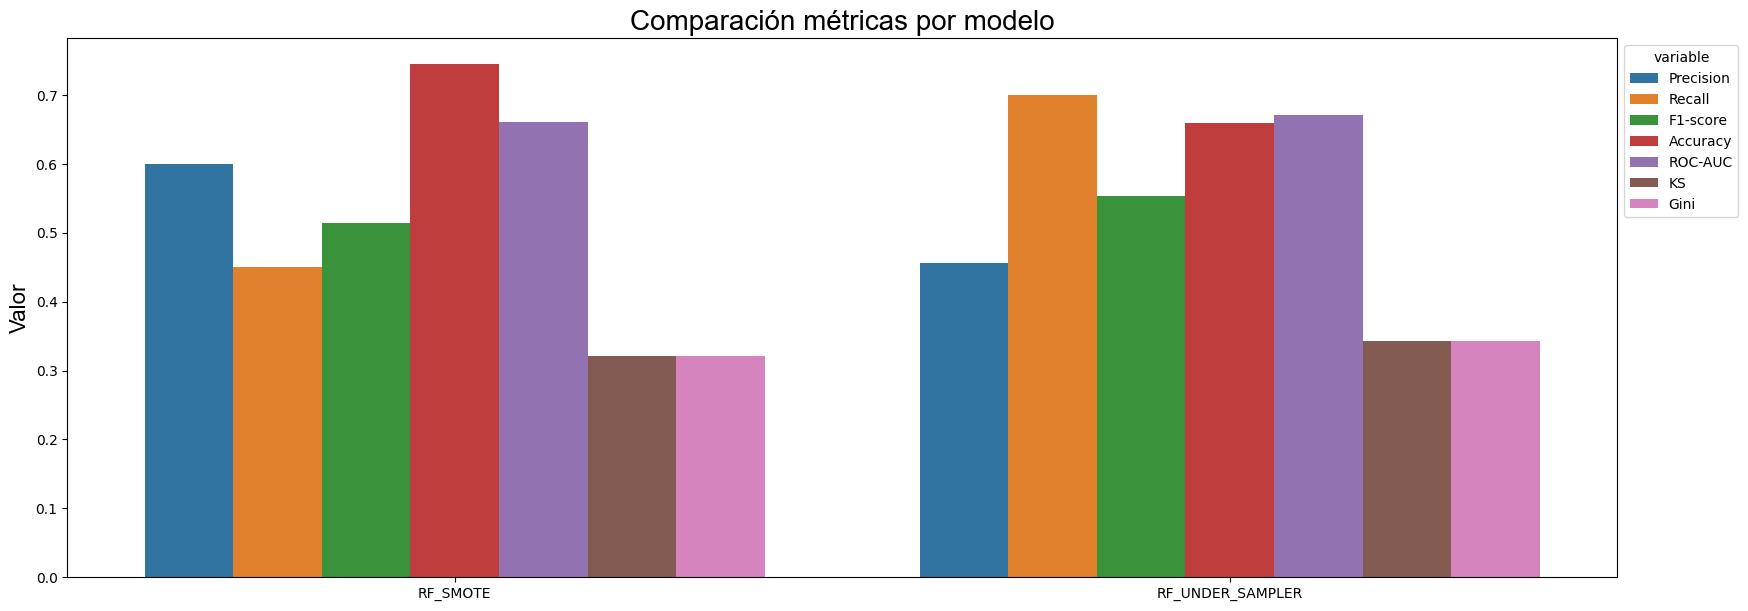

In [197]:
results_df = pd.DataFrame(results)
results_df = results_df.drop('Modelo', axis=1)

results_df = results_df.melt(
    id_vars=['Algoritmo']
)

fig, ax = plt.subplots(figsize=(20, 7))
g = sns.barplot(data=results_df, hue='variable', x='Algoritmo', y='value', ax=ax)
sns.move_legend(g, "upper left", bbox_to_anchor=(1,1))
ax.set_title("Comparación métricas por modelo", fontdict={'fontname':'Arial', 'fontsize':20})
ax.set_ylabel("Valor", fontdict={'fontname':'Arial', 'fontsize': 16})
ax.set_xlabel(None, fontdict={'fontname':'Arial', 'fontsize': 16})
plt.show()

In [198]:
pd.DataFrame(results).drop('Modelo', axis=1).set_index('Algoritmo').style.highlight_max(color='purple', axis=0)

,Precision,Recall,F1-score,Accuracy,ROC-AUC,KS,Gini
Algoritmo,,,,,,,
RF_SMOTE,0.600000,0.450000,0.514286,0.745000,0.660714,0.321429,0.321429
RF_UNDER_SAMPLER,0.456522,0.700000,0.552632,0.660000,0.671429,0.342857,0.342857


Luego de aplicar balanceo de datos no se observa una mejora significativa en el modelo en este caso